In [2]:
from ATT3D_train import *
from shapley import *
from utils import *
from vis_attention import *
from rdkit import Chem

In [3]:
# Load pKa prediction model

reg_model_mat = ATT(multihead_attention=True, return_attention=True, edge_dim=12, num_features=33)
reg_model_mat_path = "/home/lxy/ATT/best_model_3d_pre.pth"
reg_model_mat.load_state_dict(torch.load(reg_model_mat_path, map_location=torch.device('cpu')))
print("Load pretrained model")
reg_model_mat.eval()

Load pretrained model


ATT(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (initial_conv): GATConv(33, 128, heads=4)
  (head_transform1): Linear(in_features=512, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GATConv(128, 128, heads=4)
  (head_transform2): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 128, heads=4)
  (head_transform3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(128, 128, heads=4)
  (head_transform4): Linear(in_features=512, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mhat): MultiAtomAttention(
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (W_a_q): Linear(in_features=128, out_features=1

## Compare attention weights for pKa prediction before and after correction

In [37]:
smiles = "CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]

In [38]:
# Adjust input data dimensions
if single_data.x.size(1) < 33:
    # If feature dimension is insufficient, pad with zeros
    single_data.x = F.pad(single_data.x, (0, 33 - single_data.x.size(1)), "constant", 0)
elif single_data.x.size(1) > 33:
    #  If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(single_data.x.size(1), 33)
    single_data.x = projection(single_data.x)


In [39]:
edge_attr = single_data.edge_attr

if edge_attr.size(1) < 12:
    edge_attr = F.pad(edge_attr, (0, 12 - edge_attr.size(1)), "constant", 0)
elif edge_attr.size(1) > 12:
    #  If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(edge_attr.size(1), 12)
    edge_attr = projection(edge_attr)

# Update single_data.edge_attr
single_data.edge_attr = edge_attr

In [40]:
# Extract original multi-head global attention
mol_attention1_before = extract_multi_head_attention(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat)

# Corrected multi-head global attention
mol_attention1_after = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

Main visualization saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_3d.svg
Colorbar with thick border saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_c3d.svg


(None,
 tensor([3.2914e+00, 3.1448e+00, 1.4879e+00, 3.2073e-02, 3.2073e-02, 1.4879e+00,
         3.8426e-01, 1.5212e-18, 3.8425e-01, 7.1718e-26, 3.0093e-27, 1.6151e-20,
         2.3712e-03, 2.4717e-01, 1.0000e+01, 2.7820e-01, 5.5477e-02, 1.5978e-02,
         8.4523e-02, 1.5978e-02, 5.5477e-02]))

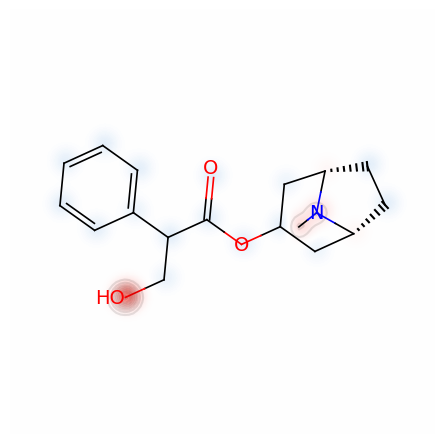

In [41]:
# Before correction
visualize_attention(smiles,mol_attention1_before,output_path='/home/lxy/ATT/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_3d.svg',colorbar_path='/home/lxy/ATT/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_c3d.svg'), mol_attention1_before.sum(axis=0)

Main visualization saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_3da.svg
Colorbar with thick border saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_c3da.svg


(None,
 tensor([0.4147, 2.7565, 1.0227, 0.5790, 0.5790, 1.0227, 0.9141, 1.1307, 0.9141,
         1.0716, 0.7548, 0.8992, 1.6727, 0.8164, 0.5155, 1.2639, 1.0445, 0.8617,
         0.8600, 0.8617, 1.0445]))

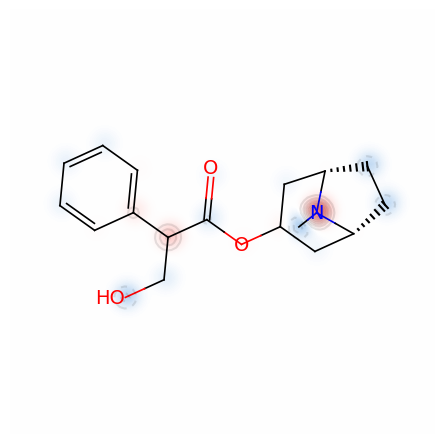

In [42]:
# After correction
visualize_attention(smiles, mol_attention1_after,output_path='/home/lxy/ATT/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_3da.svg',colorbar_path='/home/lxy/ATT/img/CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3_c3da.svg'), mol_attention1_after.sum(axis=0)

## Determine the contribution of important susbtructures with Shapley values

In [43]:
smiles = "CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]
m = Chem.MolFromSmiles(smiles)



In [44]:
# Adjust input data dimensions
if single_data.x.size(1) < 33:
    # If feature dimension is insufficient, pad with zeros
    single_data.x = F.pad(single_data.x, (0, 33 - single_data.x.size(1)), "constant", 0)
elif single_data.x.size(1) > 33:
    #  If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(single_data.x.size(1), 33)
    single_data.x = projection(single_data.x)


In [45]:
edge_attr = single_data.edge_attr

if edge_attr.size(1) < 12:
    edge_attr = F.pad(edge_attr, (0, 12 - edge_attr.size(1)), "constant", 0)
elif edge_attr.size(1) > 12:
    #  If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(edge_attr.size(1), 12)
    edge_attr = projection(edge_attr)

# Update single_data.edge_attr
single_data.edge_attr = edge_attr

In [46]:
# Corrected attention
corrected_attention = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

<Figure size 2400x1800 with 0 Axes>

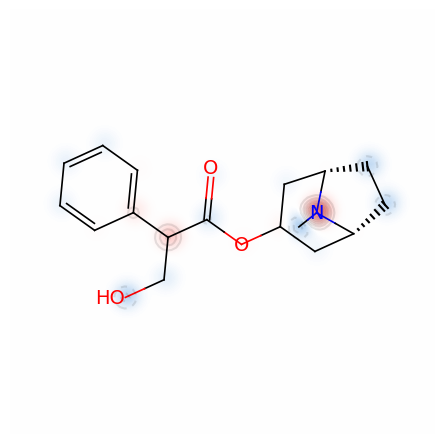

(None,
 tensor([0.4147, 2.7565, 1.0227, 0.5790, 0.5790, 1.0227, 0.9141, 1.1307, 0.9141,
         1.0716, 0.7548, 0.8992, 1.6727, 0.8164, 0.5155, 1.2639, 1.0445, 0.8617,
         0.8600, 0.8617, 1.0445]))

In [47]:
# Show important substructures
visualize_attention(smiles, corrected_attention), mol_attention1_after.sum(axis=0)

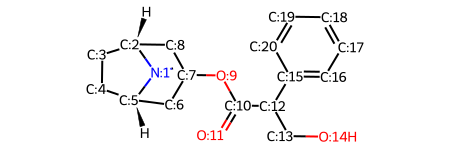

In [48]:
# Check atom index
mol_with_atom_index(m)

In [49]:
# The index of aromatic amine is 0,1
important_substuctures = [[1,2]]


# Calculate shapley values
calc_subgraphs_shapley(reg_model_mat, single_data, important_substuctures, value_func_pred)

{(1, 2): -0.21992483214240394}

In [50]:
smiles = "CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]
m = Chem.MolFromSmiles(smiles)



In [51]:
# Adjust input data dimensions
if single_data.x.size(1) < 33:
    # If feature dimension is insufficient, pad with zeros
    single_data.x = F.pad(single_data.x, (0, 33 - single_data.x.size(1)), "constant", 0)
elif single_data.x.size(1) > 33:
    #  If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(single_data.x.size(1), 33)
    single_data.x = projection(single_data.x)


In [52]:
edge_attr = single_data.edge_attr

if edge_attr.size(1) < 12:
    edge_attr = F.pad(edge_attr, (0, 12 - edge_attr.size(1)), "constant", 0)
elif edge_attr.size(1) > 12:
    #  If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(edge_attr.size(1), 12)
    edge_attr = projection(edge_attr)

# Update single_data.edge_attr
single_data.edge_attr = edge_attr

In [53]:
# Corrected attention
corrected_attention = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

<Figure size 2400x1800 with 0 Axes>

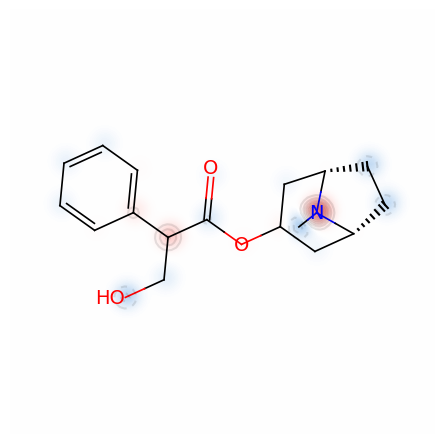

(None,
 tensor([0.4147, 2.7565, 1.0227, 0.5790, 0.5790, 1.0227, 0.9141, 1.1307, 0.9141,
         1.0716, 0.7548, 0.8992, 1.6727, 0.8164, 0.5155, 1.2639, 1.0445, 0.8617,
         0.8600, 0.8617, 1.0445]))

In [54]:
# Show important substructures
visualize_attention(smiles, corrected_attention), mol_attention1_after.sum(axis=0)

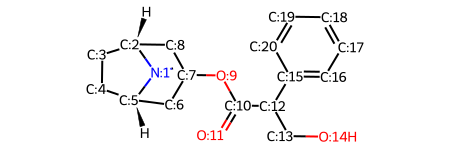

In [55]:
mol_with_atom_index(m)

In [56]:
important_substuctures = [[2,1,5]]

# Calculate shapley values
calc_subgraphs_shapley(reg_model_mat, single_data, important_substuctures, value_func_pred)

{(2, 1, 5): -0.20099440680942404}